In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
import wandb

# Load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
# Normalize images
train_images, test_images = train_images / 255.0, test_images / 255.0
# Define class names
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
#intialize wanddb
wandb.init(project="deep_learning",name='mnist_dataset')
# Select one image per class
samples_per_class = {}
for img, label in zip(train_images, train_labels):
    if label not in samples_per_class:
        samples_per_class[label] = img
    if len(samples_per_class) == len(class_names):
        break
wandb.log({"Fashion-MNIST Sample Images": [wandb.Image(img, caption=class_names[label]) for label, img in samples_per_class.items()]})

# Plot images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle("Fashion-MNIST Sample Images", fontsize=14)

for ax, (label, image) in zip(axes.flat, samples_per_class.items()):
    ax.imshow(image, cmap='gray')
    ax.set_title(class_names[label])
    ax.axis('off')

plt.tight_layout()
plt.show()
wandb.finish()

In [ ]:
#flatten the images
train_images = train_images.reshape(train_images.shape[0], -1)
test_images = test_images.reshape(test_images.shape[0], -1)

In [ ]:
import numpy as np

# Helper Functions
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # Subtract max for numerical stability
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)


def cross_entropy_loss(y_true, y_pred):
    n_samples = y_true.shape[0]
    logp = -np.log(y_pred[range(n_samples), y_true])
    return np.sum(logp) / n_samples
# Neural Network Class
class NeuralNetwork:
    def __init__(self, layer_sizes):
        self.layer_sizes = layer_sizes
        self.weights = []
        self.biases = []
        self._initialize_parameters()

    def _initialize_parameters(self):
        """Initialize weights and biases for all layers."""
        for i in range(len(self.layer_sizes) - 1):
            fan_in = self.layer_sizes[i]
            fan_out = self.layer_sizes[i + 1]
            # He initialization for hidden layers, Xavier for output layer
            if i < len(self.layer_sizes) - 2:  # Hidden layers use sigmoid
                scale = np.sqrt(2 / fan_in)
            else:  # Output layer uses softmax
                scale = np.sqrt(1 / fan_in)
            # Weight matrix: (fan_in, fan_out)
            weight = np.random.randn(fan_in, fan_out) * scale
            # Bias vector: (fan_out,)
            bias = np.zeros(fan_out)
            self.weights.append(weight)
            self.biases.append(bias)

    def forward(self, x):
        a = x  # Activation starts as the input
        # Process hidden layers
        for l in range(len(self.weights) - 1):
            z = np.dot(a, self.weights[l]) + self.biases[l]
            a = sigmoid(z)
        # Process output layer
        z = np.dot(a, self.weights[-1]) + self.biases[-1]
        output = softmax(z)
        return output

# Example Usage
if __name__ == "__main__":
    # Create a network: 784 input -> 256 hidden -> 128 hidden -> 10 output
    nn = NeuralNetwork([784, 256, 128, 10])
    # Simulate 5 input samples (e.g., Fashion-MNIST images)
    x = np.random.randn(5, 784)
    # Get probabilities
    probs = nn.forward(x)
    # Print probabilities for each sample
    for i, prob in enumerate(probs):
        print(f"Sample {i+1} probabilities: {prob}")

In [ ]:
def to_one_hot(labels, num_classes=10):
    """Convert labels to one-hot encoding."""
    return np.eye(num_classes)[labels]

# Base Optimizer Class
class Optimizer:
    """Abstract base class for optimizers."""
    def update(self, weights, biases, grads_w, grads_b):
        raise NotImplementedError("Subclasses must implement this method.")

# SGD Optimizer
class SGD(Optimizer):
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate

    def update(self, weights, biases, grads_w, grads_b):
        for i in range(len(weights)):
            weights[i] -= self.learning_rate * grads_w[i]
            biases[i] -= self.learning_rate * grads_b[i]



In [ ]:
# Momentum Optimizer
class Momentum(Optimizer):
    def __init__(self, learning_rate=0.01, momentum=0.9):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.velocity_w = None
        self.velocity_b = None

    def update(self, weights, biases, grads_w, grads_b):
        if self.velocity_w is None:
            self.velocity_w = [np.zeros_like(w) for w in weights]
            self.velocity_b = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            self.velocity_w[i] = self.momentum * self.velocity_w[i] + self.learning_rate * grads_w[i]
            self.velocity_b[i] = self.momentum * self.velocity_b[i] + self.learning_rate * grads_b[i]
            weights[i] -= self.velocity_w[i]
            biases[i] -= self.velocity_b[i]

In [ ]:
# Nesterov Optimizer
class Nesterov(Optimizer):
    def __init__(self, learning_rate=0.01, momentum=0.9):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.velocity_w = None
        self.velocity_b = None

    def update(self, weights, biases, grads_w, grads_b):
        if self.velocity_w is None:
            self.velocity_w = [np.zeros_like(w) for w in weights]
            self.velocity_b = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            # Simplified Nesterov: update with current gradients (approximation)
            self.velocity_w[i] = self.momentum * self.velocity_w[i] + self.learning_rate * grads_w[i]
            self.velocity_b[i] = self.momentum * self.velocity_b[i] + self.learning_rate * grads_b[i]
            weights[i] -= self.momentum * self.velocity_w[i]
            biases[i] -= self.momentum * self.velocity_b[i]

In [ ]:
# RMSProp Optimizer
class RMSProp(Optimizer):
    def __init__(self, learning_rate=0.001, beta=0.9, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta = beta
        self.epsilon = epsilon
        self.s_w = None
        self.s_b = None

    def update(self, weights, biases, grads_w, grads_b):
        if self.s_w is None:
            self.s_w = [np.zeros_like(w) for w in weights]
            self.s_b = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            self.s_w[i] = self.beta * self.s_w[i] + (1 - self.beta) * (grads_w[i] ** 2)
            self.s_b[i] = self.beta * self.s_b[i] + (1 - self.beta) * (grads_b[i] ** 2)
            weights[i] -= self.learning_rate * grads_w[i] / (np.sqrt(self.s_w[i] + self.epsilon))
            biases[i] -= self.learning_rate * grads_b[i] / (np.sqrt(self.s_b[i] + self.epsilon))


In [ ]:
# Adam Optimizer
class Adam(Optimizer):
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m_w = None
        self.m_b = None
        self.v_w = None
        self.v_b = None
        self.t = 0

    def update(self, weights, biases, grads_w, grads_b):
        if self.m_w is None:
            self.m_w = [np.zeros_like(w) for w in weights]
            self.m_b = [np.zeros_like(b) for b in biases]
            self.v_w = [np.zeros_like(w) for w in weights]
            self.v_b = [np.zeros_like(b) for b in biases]
        self.t += 1
        for i in range(len(weights)):
            self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * grads_w[i]
            self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * grads_b[i]
            self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (grads_w[i] ** 2)
            self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (grads_b[i] ** 2)
            m_w_hat = self.m_w[i] / (1 - self.beta1 ** self.t)
            m_b_hat = self.m_b[i] / (1 - self.beta1 ** self.t)
            v_w_hat = self.v_w[i] / (1 - self.beta2 ** self.t)
            v_b_hat = self.v_b[i] / (1 - self.beta2 ** self.t)
            weights[i] -= self.learning_rate * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
            biases[i] -= self.learning_rate * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)


In [ ]:
# Nadam Optimizer
class Nadam(Optimizer):
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m_w = None
        self.m_b = None
        self.v_w = None
        self.v_b = None
        self.t = 0

    def update(self, weights, biases, grads_w, grads_b):
        if self.m_w is None:
            self.m_w = [np.zeros_like(w) for w in weights]
            self.m_b = [np.zeros_like(b) for b in biases]
            self.v_w = [np.zeros_like(w) for w in weights]
            self.v_b = [np.zeros_like(b) for b in biases]
        self.t += 1
        for i in range(len(weights)):
            self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * grads_w[i]
            self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * grads_b[i]
            self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (grads_w[i] ** 2)
            self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (grads_b[i] ** 2)
            m_w_hat = self.m_w[i] / (1 - self.beta1 ** self.t)
            m_b_hat = self.m_b[i] / (1 - self.beta1 ** self.t)
            v_w_hat = self.v_w[i] / (1 - self.beta2 ** self.t)
            v_b_hat = self.v_b[i] / (1 - self.beta2 ** self.t)
            m_w_nesterov = self.beta1 * m_w_hat + (1 - self.beta1) * grads_w[i] / (1 - self.beta1 ** self.t)
            m_b_nesterov = self.beta1 * m_b_hat + (1 - self.beta1) * grads_b[i] / (1 - self.beta1 ** self.t)
            weights[i] -= self.learning_rate * m_w_nesterov / (np.sqrt(v_w_hat) + self.epsilon)
            biases[i] -= self.learning_rate * m_b_nesterov / (np.sqrt(v_b_hat) + self.epsilon)


In [ ]:
import numpy as np
import wandb
from sklearn.model_selection import train_test_split
def cross_entropy_loss(y_true, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]
# Neural Network class
class NeuralNetwork:
    def __init__(self, layer_sizes, activation='relu', weight_init='xavier'):
        self.layer_sizes = layer_sizes
        self.num_layers = len(layer_sizes)
        self.activation = activation
        self.weight_init = weight_init
        self.weights = []
        self.biases = []
        for i in range(1, self.num_layers):
            fan_in = layer_sizes[i-1]
            fan_out = layer_sizes[i]
            if weight_init == 'xavier':
                weight = np.random.randn(fan_out, fan_in) * np.sqrt(2 / (fan_in + fan_out))
            else:  # random
                weight = np.random.randn(fan_out, fan_in) * 0.01
            bias = np.zeros(fan_out)
            self.weights.append(weight)
            self.biases.append(bias)
    def forward(self, X, training=False):
        a = X
        if training:
            self.activations = [a]
            self.zs = []
        for l in range(self.num_layers - 1):
            z = np.dot(a, self.weights[l].T) + self.biases[l]
            if training:
                self.zs.append(z)
            if l < self.num_layers - 2:
                if self.activation == 'relu':
                    a = relu(z)
                elif self.activation == 'sigmoid':
                    a = sigmoid(z)
                elif self.activation == 'tanh':
                    a = np.tanh(z)
            else:
                a = softmax(z)
            if training:
                self.activations.append(a)
        return a

    def backward(self, y, weight_decay=0):
        batch_size = y.shape[0]
        grads_w = []
        grads_b = []
        dz = self.activations[-1] - y
        for l in range(self.num_layers - 2, -1, -1):
            a_prev = self.activations[l]
            dW = np.dot(dz.T, a_prev) / batch_size + weight_decay * self.weights[l]
            db = np.sum(dz, axis=0) / batch_size
            grads_w.insert(0, dW)
            grads_b.insert(0, db)
            if l > 0:
                z = self.zs[l-1]
                if self.activation == 'relu':
                    sigma_prime = (z > 0).astype(float)
                elif self.activation == 'sigmoid':
                    a = sigmoid(z)
                    sigma_prime = a * (1 - a)
                elif self.activation == 'tanh':
                    a = np.tanh(z)
                    sigma_prime = 1 - a**2
                dz = np.dot(dz, self.weights[l]) * sigma_prime
        return grads_w, grads_b

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, optimizer, weight_decay=0):
        num_samples = X_train.shape[0]
        y_train_onehot = to_one_hot(y_train, 10)
        y_val_onehot = to_one_hot(y_val, 10)

        for epoch in range(epochs):
            # Training phase
            train_loss = 0
            indices = np.random.permutation(num_samples)
            X_shuffled = X_train[indices]
            y_shuffled = y_train_onehot[indices]
            for i in range(0, num_samples, batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]
                y_pred_batch = self.forward(X_batch, training=True)
                train_loss += cross_entropy_loss(y_batch, y_pred_batch) * X_batch.shape[0]
                grads_w, grads_b = self.backward(y_batch, weight_decay)
                optimizer.update(self.weights, self.biases, grads_w, grads_b)
            train_loss /= num_samples  # Average training loss per sample

            # Compute training accuracy
            train_acc = self.compute_accuracy(X_train, y_train)

            # Validation phase
            y_pred_val = self.forward(X_val, training=False)
            val_loss = cross_entropy_loss(y_val_onehot, y_pred_val)
            val_acc = self.compute_accuracy(X_val, y_val)

            # Log metrics to Wandb
            # wandb.log({
            #     'epoch': epoch + 1,
            #     'train_loss': train_loss,
            #     'train_accuracy': train_acc,
            #     'val_loss': val_loss,
            #     'val_accuracy': val_acc
            # })
            # val_loss,val_acc,
        return  grads_b, grads_w

        # # Final metrics after training
        # final_train_loss = cross_entropy_loss(y_train_onehot, self.forward(X_train, training=False))
        # final_val_loss = val_loss
        # final_val_acc = val_acc
        # wandb.log({
        #     'final_train_loss': final_train_loss,
        #     'final_val_loss': final_val_loss,
        #     'final_val_accuracy': final_val_acc
        # })

        # return final_val_acc, final_val_loss

    def predict(self, X):
        return self.forward(X, training=False)

    def compute_accuracy(self, X, y):
        predictions = np.argmax(self.forward(X, training=False), axis=1)
        return np.mean(predictions == y)


# # Train the network
# x_train = train_images.reshape(train_images.shape[0], -1) / 255.0
# x_test = test_images.reshape(test_images.shape[0], -1) / 255.0
# nn = NeuralNetwork([784, 128, 10],'relu','random')
# optimizer = SGD(learning_rate=0.001)
# nn.train(x_train, train_labels, x_test, test_labels, epochs=5, batch_size=16, optimizer=optimizer)


In [ ]:
# Wandb sweap configuration
sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
    'parameters': {
        'epochs': {'values': [5, 10]},
        'num_hidden_layers': {'values': [3, 4, 5]},
        'hidden_size': {'values': [32, 64, 128]},
        'weight_decay': {'values': [0, 0.0005, 0.5]},
        'learning_rate': {'values': [1e-3, 1e-4]},
        'optimizer': {'values': ['sgd', 'momentum', 'adam','nadam', 'rmsprop','nesterov' ]},
        'batch_size': {'values': [16, 32, 64]},
        'weight_init': {'values': ['random', 'xavier']},
        'activation': {'values': ['sigmoid', 'tanh', 'relu']}
    }
}

# Training function for Wandb sweep
def train():
    config_defaults = {
        'epochs': 5,
        'num_hidden_layers': 3,
        'hidden_size': 32,
        'weight_decay': 0,
        'learning_rate': 1e-3,
        'optimizer': 'adam',
        'batch_size': 32,
        'weight_init': 'xavier',
        'activation': 'relu'
    }
    # Initialize Wandb run
    run_name = f"hl_{config_defaults['num_hidden_layers']}_bs_{config_defaults['batch_size']}_ac_{config_defaults['activation']}"
    wandb.init(config=config_defaults, name=run_name)
    config = wandb.config


    X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.1, random_state=42)

    # Define network architecture
    layer_sizes = [784] + [config.hidden_size] * config.num_hidden_layers + [10]
    nn = NeuralNetwork(layer_sizes, activation=config.activation, weight_init=config.weight_init)

    # Select optimizer
    if config.optimizer == 'sgd':
        optimizer = SGD(learning_rate=config.learning_rate)
    elif config.optimizer == 'momentum':
        optimizer = Momentum(learning_rate=config.learning_rate)
    elif config.optimizer == 'adam':
        optimizer = Adam(learning_rate=config.learning_rate)
    elif config.optimizer == 'nadam':
        optimizer = Nadam(learning_rate=config.learning_rate)
    elif config.optimizer == 'rmsprop':
        optimizer = RMSProp(learning_rate=config.learning_rate)
    elif config.optimizer == 'nesterov':
        optimizer = Nesterov(learning_rate=config.learning_rate)

    # Train the model
    val_acc, val_loss = nn.train(X_train, y_train, X_val, y_val, config.epochs, config.batch_size, optimizer, config.weight_decay)

    wandb.finish()

# Initialize and run the sweep
sweep_id = wandb.sweep(sweep_config, project="deep_learning")
wandb.agent(sweep_id, function=train, count=50)
wandb.finish()

In [ ]:

from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, y_val = train_test_split(train_images, train_labels, test_size=0.1, random_state=42)
#flatten the images
X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
X_val = X_val.reshape(X_val.shape[0], -1) / 255.0
test_images = test_images.reshape(test_images.shape[0], -1) / 255.0


In [ ]:
# Assuming best_config from sweep (update with actual best after sweep)
best_config = {
    'epochs': 10, 'num_hidden_layers': 4, 'hidden_size': 64, 'weight_decay': 0.0005,
    'learning_rate': 1e-3, 'optimizer': 'nadam', 'batch_size': 64,
    'initialization': 'xavier', 'activation': 'tanh'
}

layer_sizes = [784] + [best_config['hidden_size']] * best_config['num_hidden_layers'] + [10]
model = NeuralNetwork(layer_sizes, best_config['activation'], best_config['initialization'])
optimizer = Nadam(best_config['learning_rate'])
model.train(X_train,Y_train, X_val, y_val, best_config['epochs'], best_config['batch_size'], optimizer, best_config['weight_decay'])


([array([-0.54642477,  1.43748018,  0.60882921, -0.03065193, -1.87786051,
          1.67796269,  0.70857226, -1.12992651,  0.59289265,  2.1427712 ,
          1.01569625, -1.5849685 , -1.44568142, -0.56075302,  1.4533074 ,
          1.56326419,  0.56783671, -3.21785373, -0.47202402,  2.32855918,
          1.99830354, -1.84819534, -1.52231655, -2.32299935, -2.8262973 ,
          2.26924567, -0.6223017 , -1.36836997, -3.12199647, -0.37044225,
          1.49494545, -0.61132644, -0.33914398, -1.67313627,  1.53861177,
          0.94371835,  1.17476829,  1.73738385,  0.19977682,  1.7255582 ,
         -1.66873446, -0.67003181,  0.30116971, -0.59452642, -1.53741533,
          1.18846958,  0.22011647,  1.50996361, -2.32637944,  0.41364198,
          1.97910933,  0.9683946 , -1.91187736, -0.74996734, -0.41500598,
          0.32598346, -2.9575569 ,  0.84778671, -1.06207029,  2.33459233,
          1.16696359, -0.19183414, -1.51863436,  1.35645807]),
  array([-0.24726165,  0.28375881,  0.37612996, -

Confusion Matrix:
[[782   3  12  73   2   2 113   0  13   0]
 [  2 928  17  48   3   0   1   0   1   0]
 [ 14   0 663  11 151   0 151   0  10   0]
 [ 43  10   8 839  27   1  64   0   8   0]
 [  0   0 104  36 689   0 161   0  10   0]
 [  0   0   0   1   0 902   0  52  12  33]
 [153   2  90  54  81   1 592   0  27   0]
 [  0   0   0   0   0  45   0 871   0  84]
 [  2   1   2  10   2   7  29   4 940   3]
 [  0   0   0   0   0  19   0  26   4 951]]


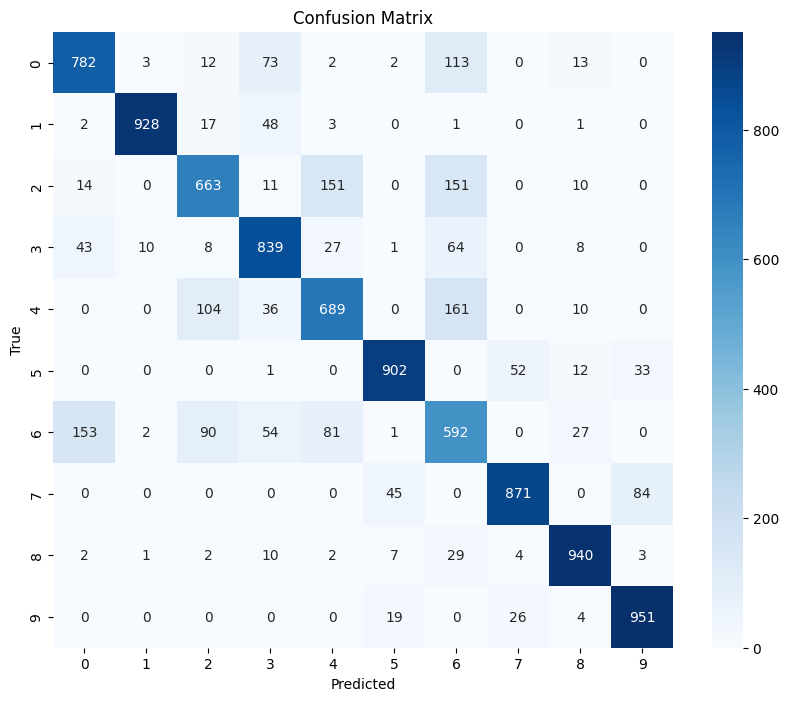

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import wandb

# Initialize wandb run
wandb.init(project="deep_learning", name='confusion_matrix')

# Generate predictions
y_pred_val = model.predict(test_images)
y_pred_val_classes = np.argmax(y_pred_val, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, y_pred_val_classes)

# Optional: Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Log the confusion matrix plot to wandb
wandb.log({"confusion_matrix": wandb.Image(plt.gcf())})

# Show the plot (optional)
plt.show()

# Finish the wandb run
wandb.finish()